In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import functional as F
from torchmetrics import Accuracy

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from scipy.stats import skew, kurtosis # для расчета ассиметрии и эксцесса

from tqdm.autonotebook import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

plt.style.use('dark_background')
warnings.filterwarnings('ignore', 'FutureWarning')

In [2]:
df = load_iris()

In [3]:
X = df.data
y = df.target

In [4]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

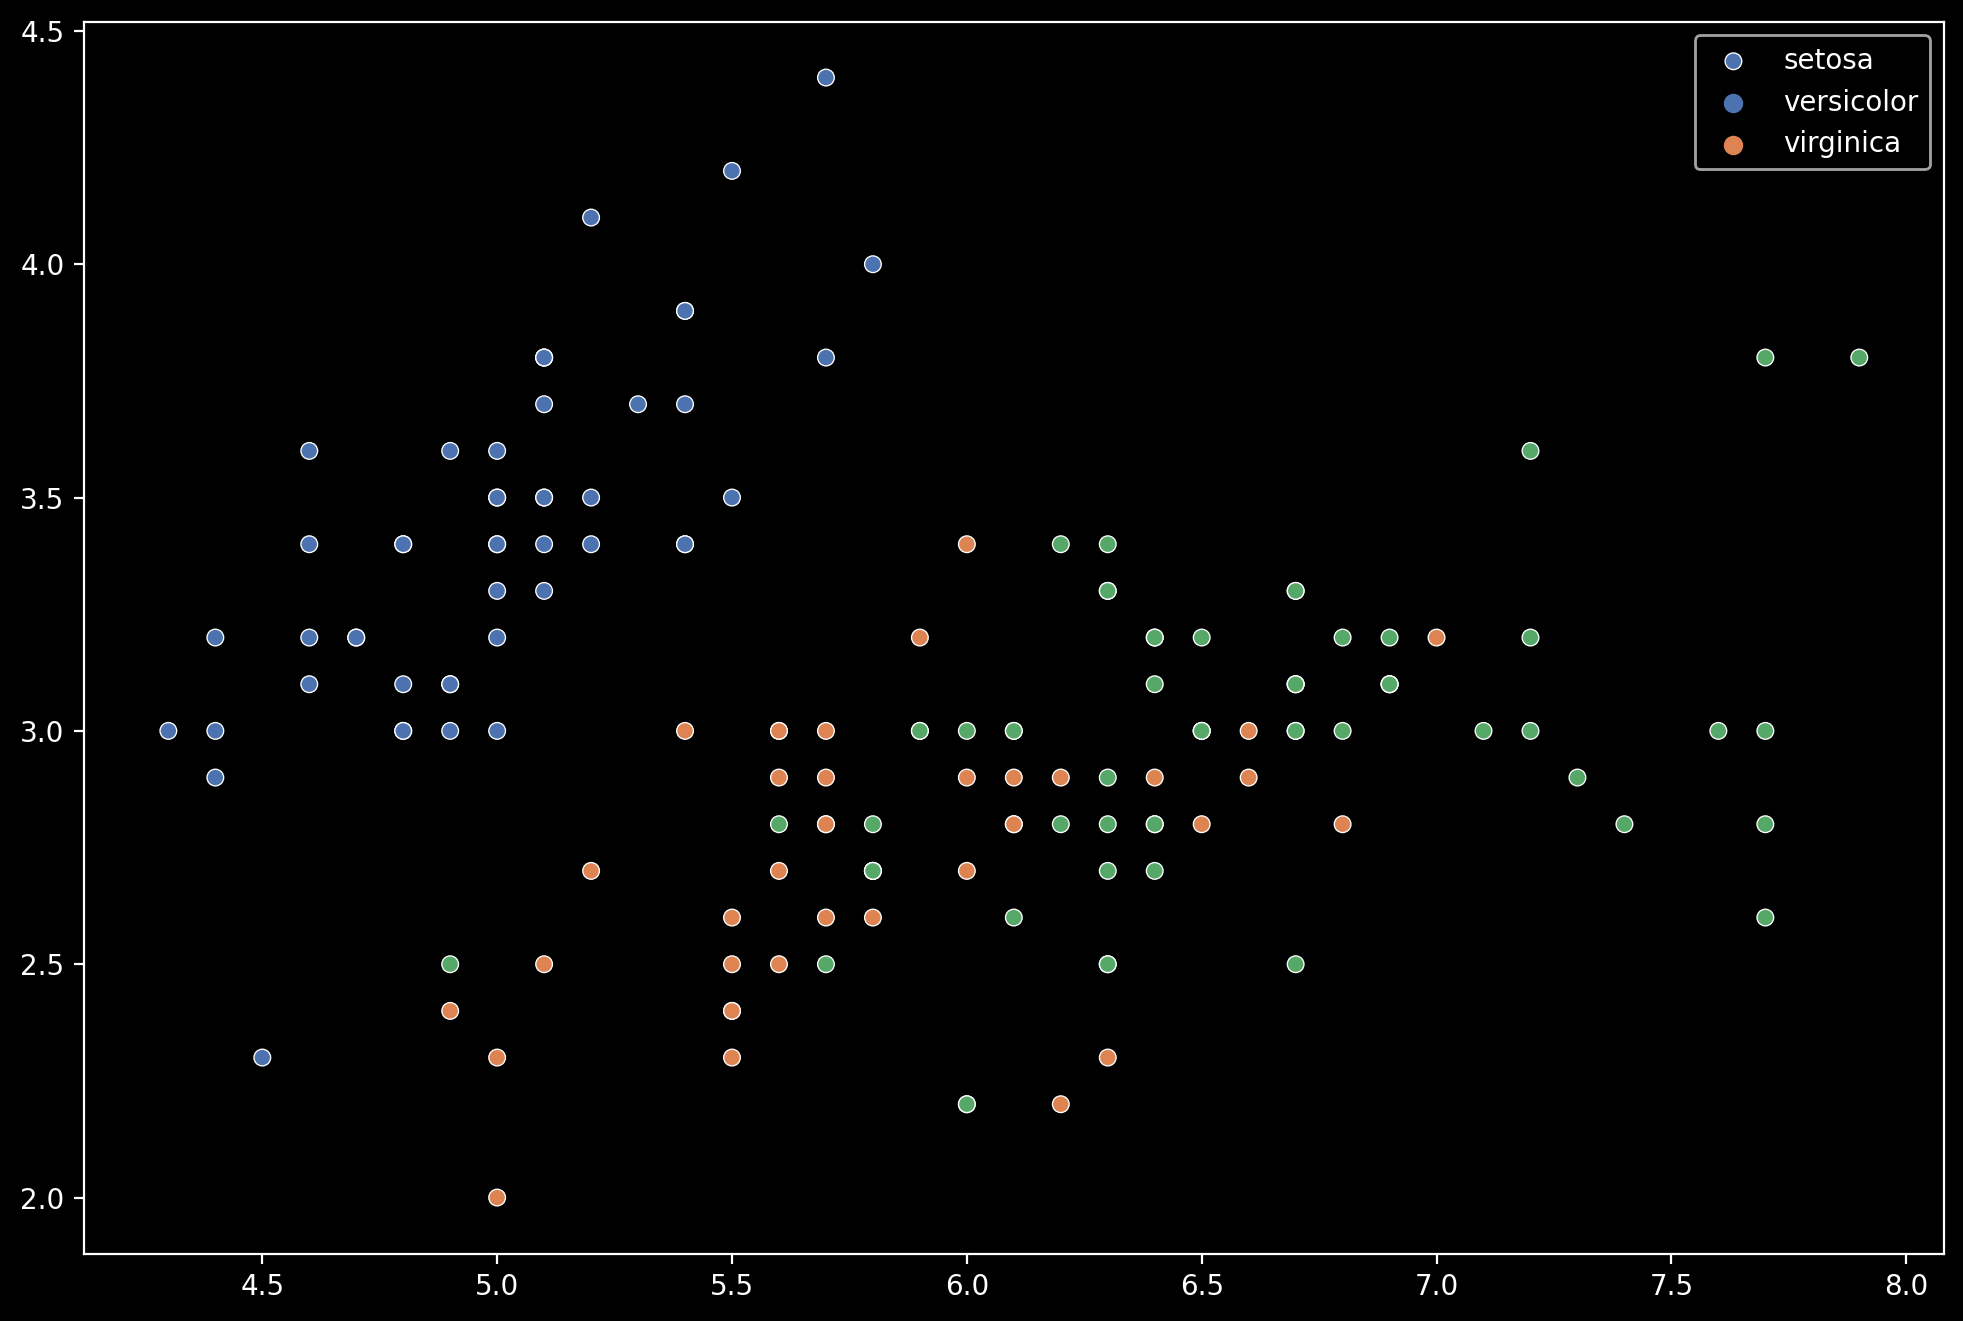

In [5]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(x=X[:, 0], y=X[: , 1], hue=y, palette='deep')
plt.legend(df.target_names)

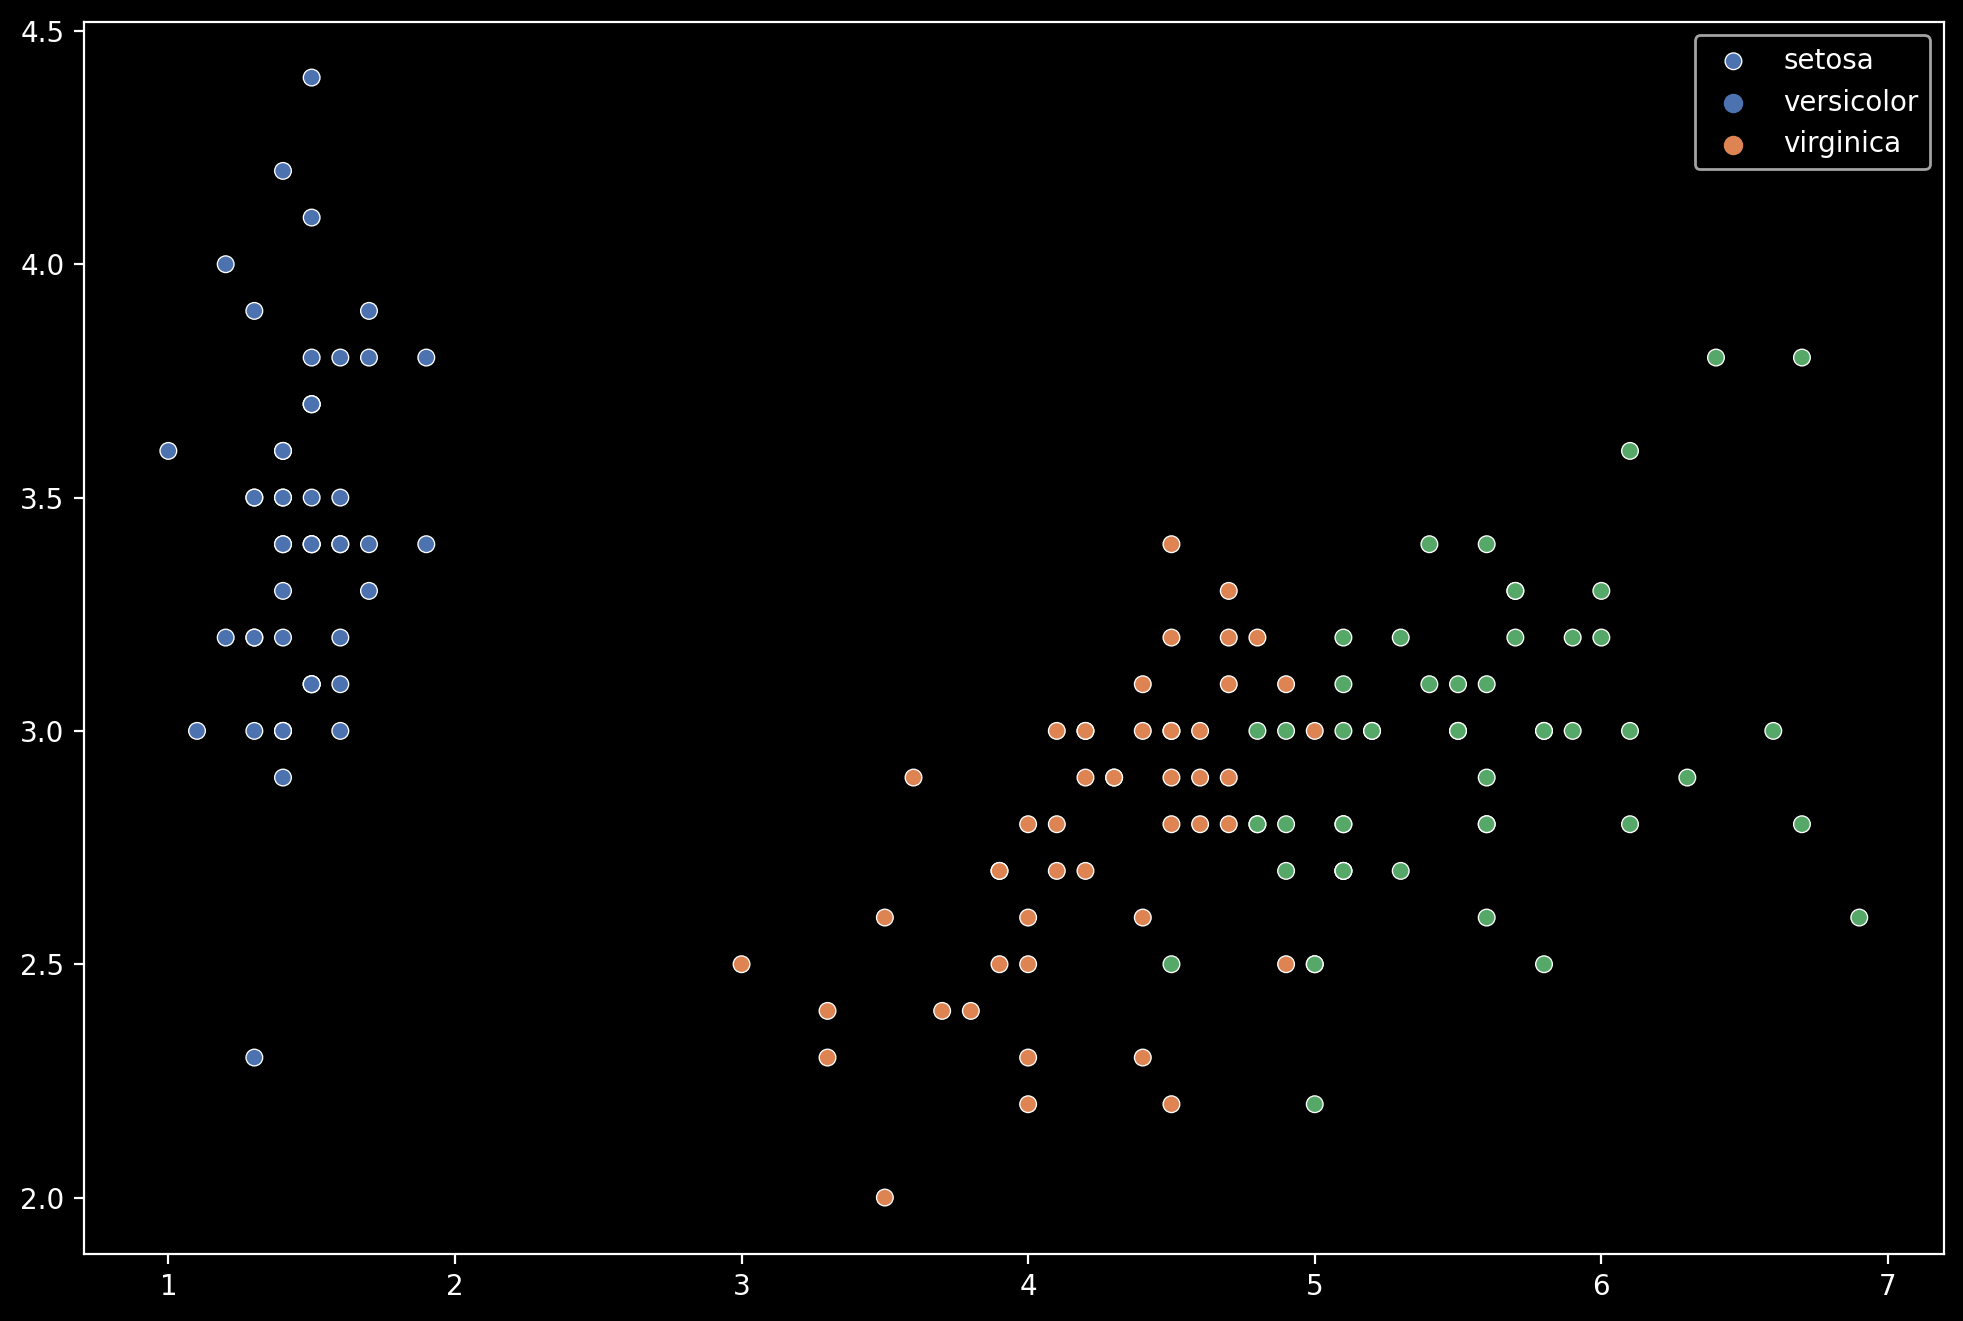

In [6]:
plt.figure(figsize=(12, 8), dpi=200)
sns.scatterplot(x=X[:, 2], y=X[: , 1], hue=y, palette='deep')
plt.legend(df.target_names)

In [7]:
## Проверка ассиметрии и эксцесса
for i in range(X.shape[1]):
    print(f'Ассиметрия для {i} столбца: {skew(X[i])}')
    print(f'Эксцесс для {i} столбца: {kurtosis(X[i])}')
    print('-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --')

Ассиметрия для 0 столбца: 0.10930877557252594
Эксцесс для 0 столбца: -1.5158456140350873
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
Ассиметрия для 1 столбца: 0.2334739034132566
Эксцесс для 1 столбца: -1.3455898586071946
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
Ассиметрия для 2 столбца: 0.12054060060886698
Эксцесс для 2 столбца: -1.503554207155315
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
Ассиметрия для 3 столбца: 0.0693570478655749
Эксцесс для 3 столбца: -1.4100226938638487
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --


## Подготовка данных к обучению

In [8]:
lim = 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.25, random_state=105)
X_val = X_train[:lim]
y_val = y_train[:lim]
X_train = X_train[lim:]
y_train = y_train[lim:]

In [9]:
X_train.shape, X_val.shape, X_test.shape

((80, 4), (20, 4), (50, 4))

In [10]:
# Перевод в тензоры
train_X = torch.from_numpy(X_train).to(torch.float32)
train_y = torch.from_numpy(y_train).to(torch.int64)
val_X = torch.from_numpy(X_val).type_as(train_X)
val_y = torch.from_numpy(y_val).type_as(train_y)
test_X = torch.from_numpy(X_test).type_as(train_X)
test_y = torch.from_numpy(y_test).type_as(val_y)

In [11]:
BATCH = 4
# создание датасетов
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)
test_dataset = TensorDataset(test_X, test_y)
# создание загрузчиков
train_loader = DataLoader(train_dataset, batch_size=BATCH)
val_loader = DataLoader(val_dataset, batch_size=BATCH)
test_loader = DataLoader(test_dataset, batch_size=BATCH)

In [12]:
next(iter(train_loader))

[tensor([[5.7000, 2.5000, 5.0000, 2.0000],
         [5.5000, 4.2000, 1.4000, 0.2000],
         [6.0000, 3.0000, 4.8000, 1.8000],
         [5.8000, 2.7000, 5.1000, 1.9000]]),
 tensor([2, 0, 2, 2])]

In [13]:
# Определяем устройство с которого будет производиться обучение нейронной сети (CPU, GPU)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
DEVICE

'cpu'

## Полносвязная сеть pytorch

In [72]:
class IrisNN(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.lin_input = self.make_layer(in_features, in_features * 20)
        self.lin_linear2 = self.make_layer(in_features * 20, out_features)
        self.relu = F.relu
        self.sigmoid = F.sigmoid
    
    # создание слоя
    def make_layer(self, in_feat, out_feat):
        return nn.Linear(in_feat, out_feat)
    
    # прямой проход нейронной сети
    def forward(self, x):
        x = self.lin_input(x)
        x = self.relu(x)
        
        x = self.lin_linear2(x)
        return x
    # предсказание
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            predict = self(x.to(DEVICE))
        return predict

## Обучение

In [83]:
# Подготовка
model = IrisNN(4, 3)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [84]:
# Поместить модель и метрику на cuda
model = model.to(DEVICE)
accuracy = Accuracy(task='multiclass', num_classes=3).to(DEVICE)

In [85]:
# создать вспомогательные списки для данных
# лосс на каждой итерации
losses_train = []
losses_val = []
# общий лосс
total_loss = []
total_val_loss = []
# accuracy
acc_val = []
# Общее количество эпох
MAX_EPOCHS = 150
size = len(train_loader.dataset) # Размер датасета
for epoch in tqdm(range(MAX_EPOCHS)):
    print(f'Epochs {epoch + 1}\n--------------------')
    for iteration, (X_batch, y_batch) in enumerate(train_loader):
        # ЭТАП ОБУЧЕНИЯ
        # переводим модель в режим обучения
        model.train()
        # обнуляем коэффициенты у оптимизатора
        optimizer.zero_grad()
        # Пропускаем данные через модель
        outputs = model(X_batch.to(DEVICE))
        # Выравниваем выходы в одномерный тензор
        # outputs = outputs.view(-1)
        # считаем лосс
        loss = loss_function(outputs, y_batch.to(DEVICE))
        # Делаем шаг в обратном направлении
        loss.backward()
        # Собираем лоссы
        losses_train.append(loss.detach().cpu().numpy().item())
        # Делаем шаг оптимизатора 
        optimizer.step()
        if len(X_batch) == 1:
            current = size
        else:
            current = (iteration + 1) * len(X_batch)
        print(f'loss: {loss:>7f} [{current:>3d}|{size:>2d}]')
    # Собираем средний лосс
    total_loss.append(np.mean(losses_train))
    # ШАГ ВАЛИДАЦИИ
    for iteration, (X_val, y_val) in enumerate(val_loader):
        # режим инференса, валидации или тестирования
        model.eval()
        with torch.no_grad():
            outputs = model(X_batch.to(DEVICE))
            # outputs.view(-1)
            # считаем loss
            loss = loss_function(outputs, y_batch.to(DEVICE))
            losses_val.append(loss)
            # считаем вероятности
            proba = torch.sigmoid(outputs)
            # считаем метрику
            batch_acc = accuracy(proba, y_batch.to(torch.int32).to(DEVICE))
            acc_val.append(batch_acc.detach().cpu().numpy().item())
    total_val_loss.append(np.mean(losses_val))
    print(f'Validation Error: \n Accuracy: {np.mean(acc_val)} Avg Loss: {np.mean(losses_val)}')

  0%|          | 0/150 [00:00<?, ?it/s]

Epochs 1
--------------------
loss: 2.072184 [  4|80]
loss: 1.208304 [  8|80]
loss: 1.333503 [ 12|80]
loss: 0.975494 [ 16|80]
loss: 1.262910 [ 20|80]
loss: 1.468064 [ 24|80]
loss: 1.305135 [ 28|80]
loss: 1.552645 [ 32|80]
loss: 1.202201 [ 36|80]
loss: 1.336881 [ 40|80]
loss: 1.187404 [ 44|80]
loss: 1.256162 [ 48|80]
loss: 0.997693 [ 52|80]
loss: 1.007890 [ 56|80]
loss: 1.227265 [ 60|80]
loss: 1.227204 [ 64|80]
loss: 1.150984 [ 68|80]
loss: 0.980410 [ 72|80]
loss: 1.061104 [ 76|80]
loss: 1.064777 [ 80|80]
Validation Error: 
 Accuracy: 0.75 Avg Loss: 1.0465117692947388
Epochs 2
--------------------
loss: 1.038084 [  4|80]
loss: 0.934936 [  8|80]
loss: 1.163640 [ 12|80]
loss: 1.172142 [ 16|80]
loss: 1.163004 [ 20|80]
loss: 0.923141 [ 24|80]
loss: 1.092014 [ 28|80]
loss: 1.079649 [ 32|80]
loss: 1.056908 [ 36|80]
loss: 0.906061 [ 40|80]
loss: 0.857878 [ 44|80]
loss: 0.933849 [ 48|80]
loss: 1.124872 [ 52|80]
loss: 1.108194 [ 56|80]
loss: 0.929446 [ 60|80]
loss: 0.796298 [ 64|80]
loss: 0.9112

In [86]:
acc = np.mean(acc_val)
print(f'Accuracy: {acc:.2%}')

Accuracy: 99.50%


In [87]:
len(total_val_loss), len(total_loss)

(150, 150)

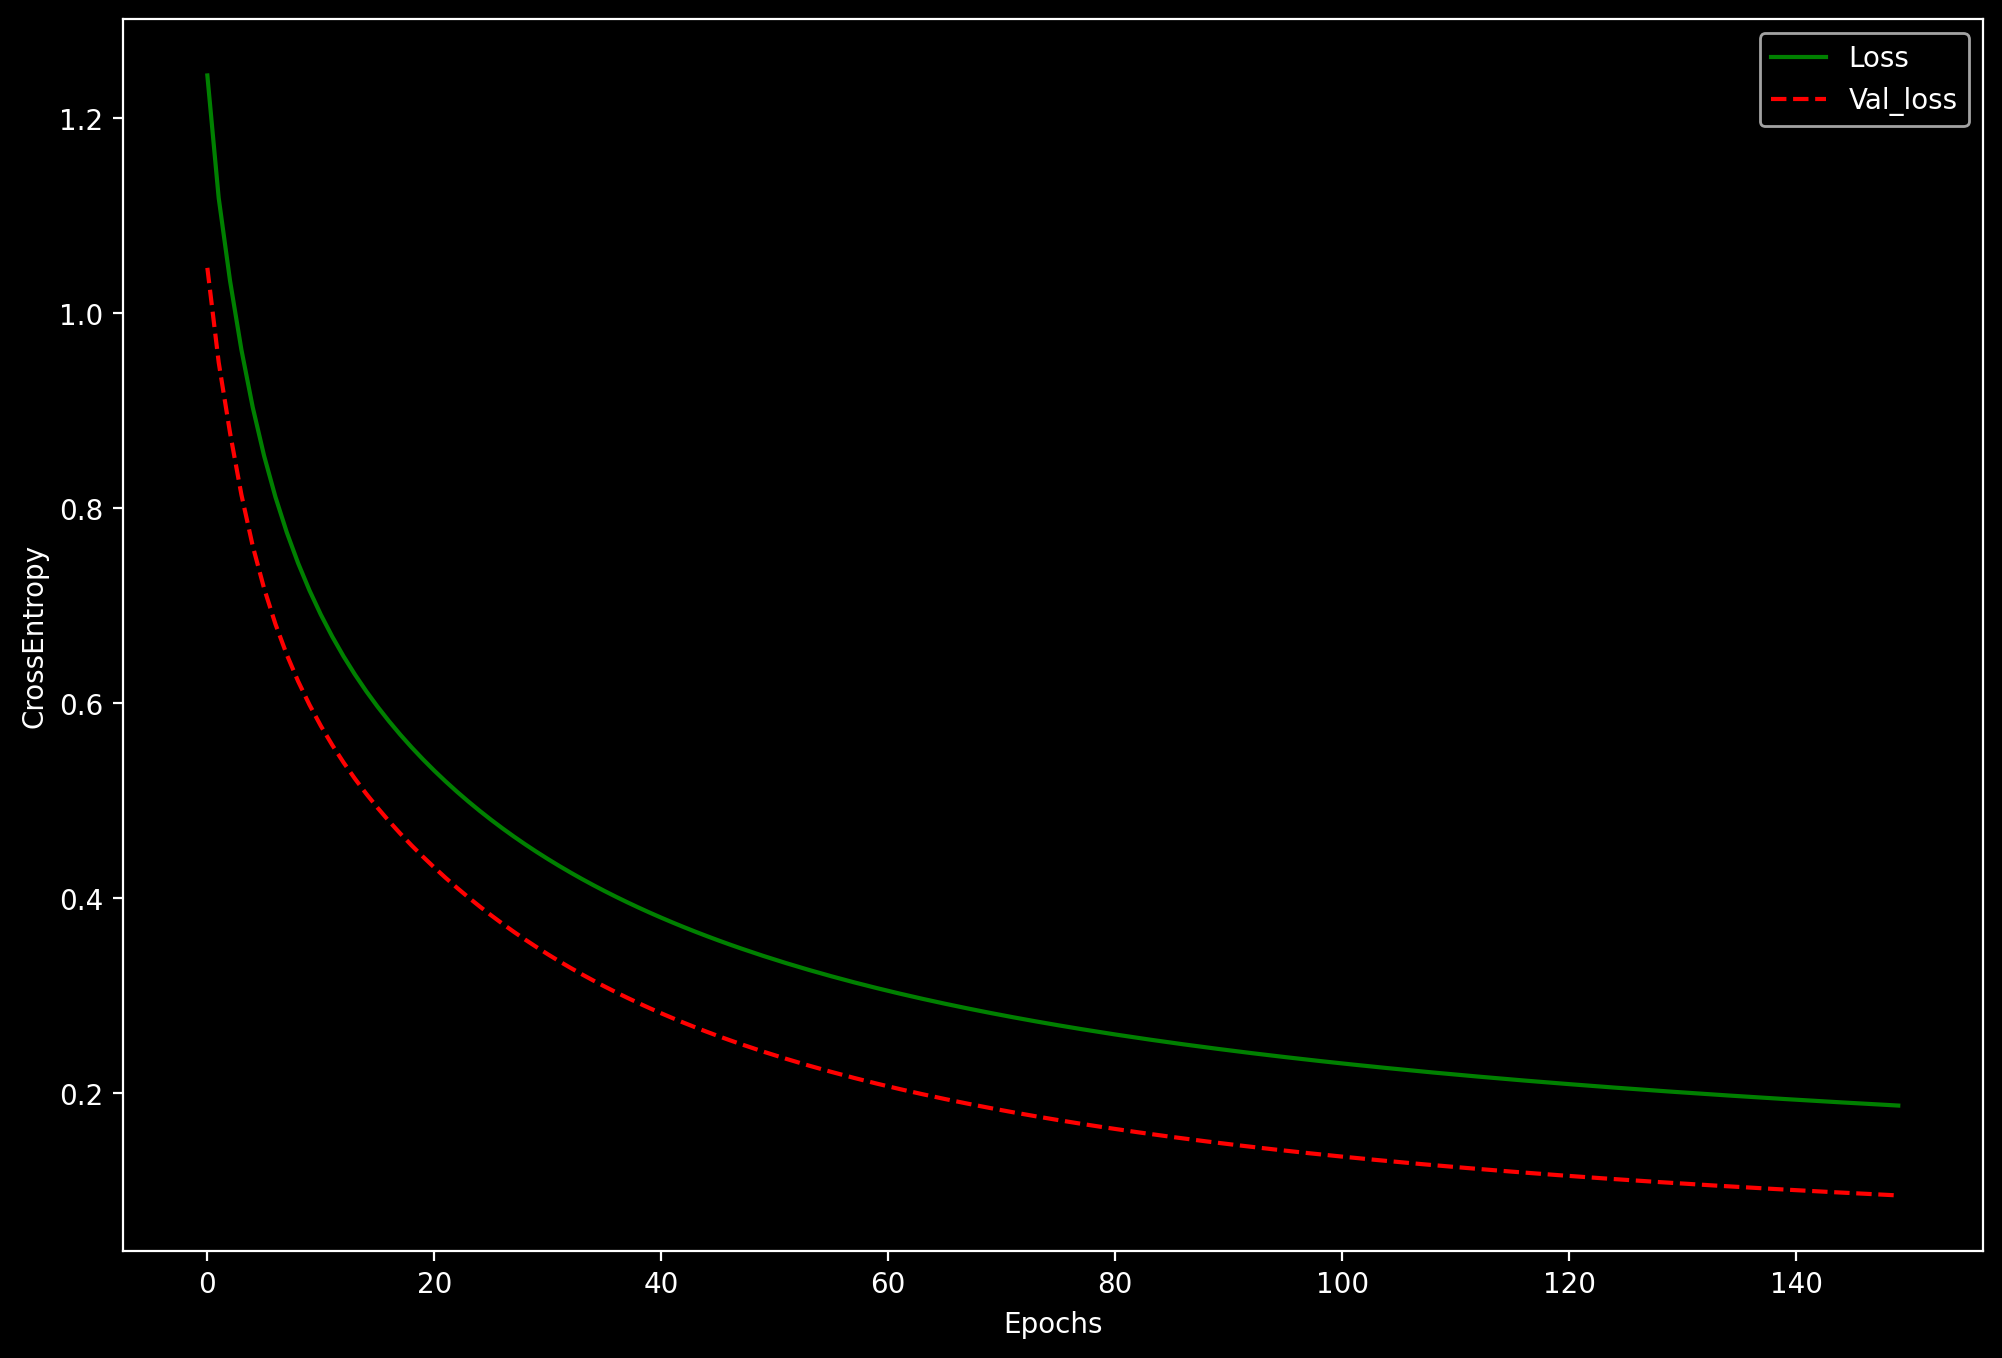

In [88]:
plt.figure(figsize=(12, 8), dpi=200)
plt.plot(total_loss, color='green', label='Loss')
plt.plot(total_val_loss, color='red', label='Val_loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('CrossEntropy')
plt.legend()

In [95]:
indx = 112 # Индекс от 0 до 149 (X.shape[0] - 1)
X_pred = torch.from_numpy(X[indx, :]).to(torch.float32)
pred = model.predict(X_pred)
clean_pred = torch.max(pred.data, 0).indices.detach().cpu().numpy().item()
print(f'Результат работы НС: {clean_pred}. Правильный ответ {y[indx]}')

Результат работы НС: 2. Правильный ответ 2


In [96]:
acc_test = []
for iteration, (X_test, y_test) in enumerate(test_loader):
    predict = model.predict(X_test)
    proba = torch.sigmoid(predict)
    acc = accuracy(proba, y_test.to(DEVICE))
    acc_test.append(acc)
print(f'Accuracy for test dataset: {np.mean(acc_test):.2%}')

Accuracy for test dataset: 98.08%
